[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [ ]:
%%capture --no-stderr
%pip install -U langchain_mistralai langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Analyze different aspects of John Mayer's music across various albums.

(2) `Reduce` - Select the most insightful analysis from the list.

We'll use an LLM to do the analysis generation and selection.

In [3]:
from langchain_mistralai import ChatMistralAI

# Prompts we will use
albums_prompt = """Generate a list of 3 John Mayer albums that are all related to this musical theme: {theme}."""
analysis_prompt = """Analyze the musical style and key characteristics of the album {album}"""
best_analysis_prompt = """Below are analyses of different John Mayer albums related to {theme}. Select the best analysis! Return the ID of the best one, starting 0 as the ID for the first analysis. Analyses: \n\n  {analyses}"""

# LLM
model = ChatMistralAI(model="mistral-large-latest", temperature=0)

## State

### Parallelizing album analysis generation

First, let's define the entry point of the graph that will:

* Take a user input musical theme
* Produce a list of John Mayer albums from it
* Send each album to our album analysis generation node

Our state has an `analyses` key, which will accumulate analyses from parallelized album analysis generation

In [4]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Albums(BaseModel):
    albums: list[str]

class BestAnalysis(BaseModel):
    id: int
    
class OverallState(TypedDict):
    theme: str
    albums: list
    analyses: Annotated[list, operator.add]
    best_selected_analysis: str

Generate albums for analysis.

In [5]:
def generate_albums(state: OverallState):
    prompt = albums_prompt.format(theme=state["theme"])
    response = model.with_structured_output(Albums).invoke(prompt)
    return {"albums": response.albums}

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create an analysis for each album.

This is very useful! It can automatically parallelize album analysis generation for any number of albums.

* `generate_analysis`: the name of the node in the graph
* `{"album": a}`: the state to send

`Send` allow you to pass any state that you want to `generate_analysis`! It does not have to align with `OverallState`.

In this case, `generate_analysis` is using its own internal state, and we can populate this via `Send`.

In [6]:
from langgraph.types import Send
def continue_to_analyses(state: OverallState):
    return [Send("generate_analysis", {"album": a}) for a in state["albums"]]

### Album analysis generation (map)

Now, we just define a node that will create our album analyses, `generate_analysis`!

We write them back out to `analyses` in `OverallState`! 

This key has a reducer that will combine lists.

In [7]:
class AlbumState(TypedDict):
    album: str

class Analysis(BaseModel):
    analysis: str

def generate_analysis(state: AlbumState):
    prompt = analysis_prompt.format(album=state["album"])
    response = model.with_structured_output(Analysis).invoke(prompt)
    return {"analyses": [response.analysis]}

### Best analysis selection (reduce)

Now, we add logic to pick the best album analysis.

In [8]:
def best_analysis(state: OverallState):
    analyses = "\n\n".join(state["analyses"])
    prompt = best_analysis_prompt.format(theme=state["theme"], analyses=analyses)
    response = model.with_structured_output(BestAnalysis).invoke(prompt)
    return {"best_selected_analysis": state["analyses"][response.id]}

## Compile

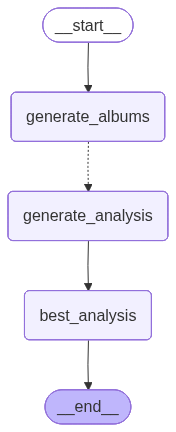

In [9]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_albums", generate_albums)
graph.add_node("generate_analysis", generate_analysis)
graph.add_node("best_analysis", best_analysis)
graph.add_edge(START, "generate_albums")
graph.add_conditional_edges("generate_albums", continue_to_analyses, ["generate_analysis"])
graph.add_edge("generate_analysis", "best_analysis")
graph.add_edge("best_analysis", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [11]:
# Call the graph: here we call it to generate album analyses
for s in app.stream({"theme": "blues guitar"}):
    print(s)

{'generate_albums': {'albums': ['Continuum', 'Try!', 'Blues Traveler & John Mayer: Live at the Beacon Theatre']}}
{'generate_analysis': {'analyses': ['Continuum by John Mayer']}}
{'generate_analysis': {'analyses': ['Try! by John Mayer Trio']}}
{'generate_analysis': {'analyses': ['Continuum by John Mayer']}}
{'generate_analysis': {'analyses': ['Try! by John Mayer Trio']}}
{'generate_analysis': {'analyses': ['Blues Traveler & John Mayer: Live at the Beacon Theatre']}}
{'generate_analysis': {'analyses': ['Blues Traveler & John Mayer: Live at the Beacon Theatre']}}
{'best_analysis': {'best_selected_analysis': 'Try! by John Mayer Trio'}}
{'best_analysis': {'best_selected_analysis': 'Try! by John Mayer Trio'}}
